In [1]:
import h5py
import numpy as np
import scipy.signal as sps
import matplotlib.pyplot as plt

In [2]:
def read_ligo(filename):
    f = h5py.File(filename, 'r')
    strain = f['strain/Strain'][...]
    fs = 1/ f['strain/Strain'].attrs['Xspacing']
    start_time = f['meta/GPSstart'][()]
    f.close()
    return strain, start_time, fs

In [3]:
# Open hdf5 files
h1_s, h1_st, h1_fs = read_ligo('../assets/data/h1_32sec_4khz.hdf5')
l1_s, l1_st, l1_fs = read_ligo('../assets/data/l1_32sec_4khz.hdf5')

In [4]:
event_start_gps = 1126259462
event_start = event_start_gps - h1_st
event_delta = 0.2
time = np.arange(0,h1_s.shape[0]/h1_fs, 1/h1_fs)

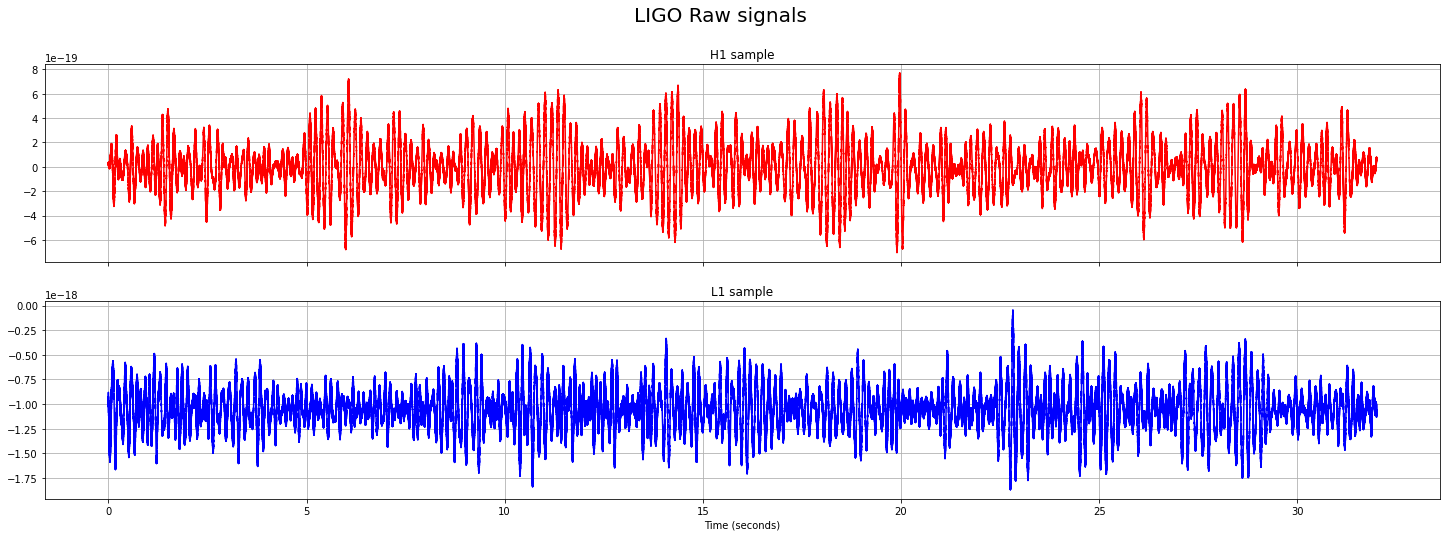

In [5]:
# Plot raw signals
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Raw signals', fontsize=20)
axs[0].plot(time, h1_s, color='red')
axs[1].plot(time, l1_s, color='blue')
axs[0].set_title('H1 sample')
axs[1].set_title('L1 sample')
axs[1].set_xlabel('Time (seconds)')
axs[0].grid()
axs[1].grid()

In [6]:
# Using a 4 second window to ensure catching events in both sites
h1_event = h1_s[(time >= event_start-2) & (time <= event_start + 2)]
l1_event = l1_s[(time >= event_start-2) & (time <= event_start + 2)]
time_event = time[(time >= event_start-2) & (time <= event_start + 2)]

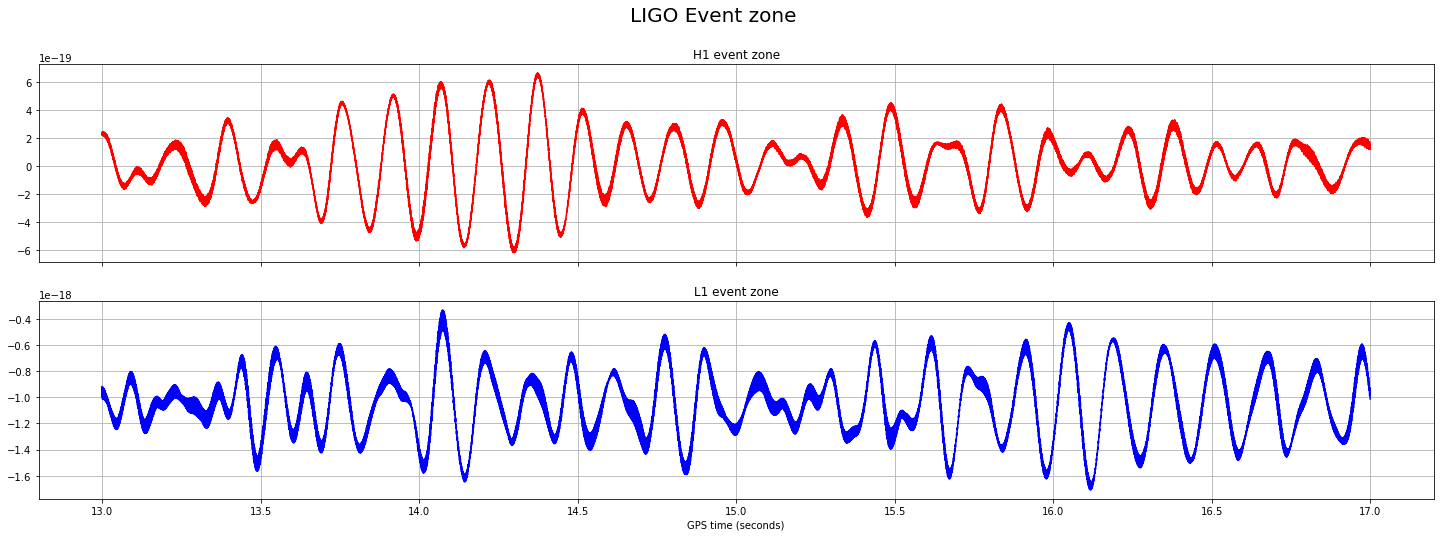

In [7]:
# Plot raw events
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Event zone',fontsize=20)
axs[0].plot(time_event, h1_event, color='red')
axs[1].plot(time_event, l1_event, color='blue')
axs[0].set_title('H1 event zone')
axs[1].set_title('L1 event zone')
axs[1].set_xlabel('GPS time (seconds)')
axs[0].grid()
axs[1].grid()

In [8]:
# Get silence (noise)
h1_silence = h1_s[(time > event_start + 2)]
l1_silence = l1_s[(time > event_start + 2)]
time_silence = time[(time > event_start + 2)]

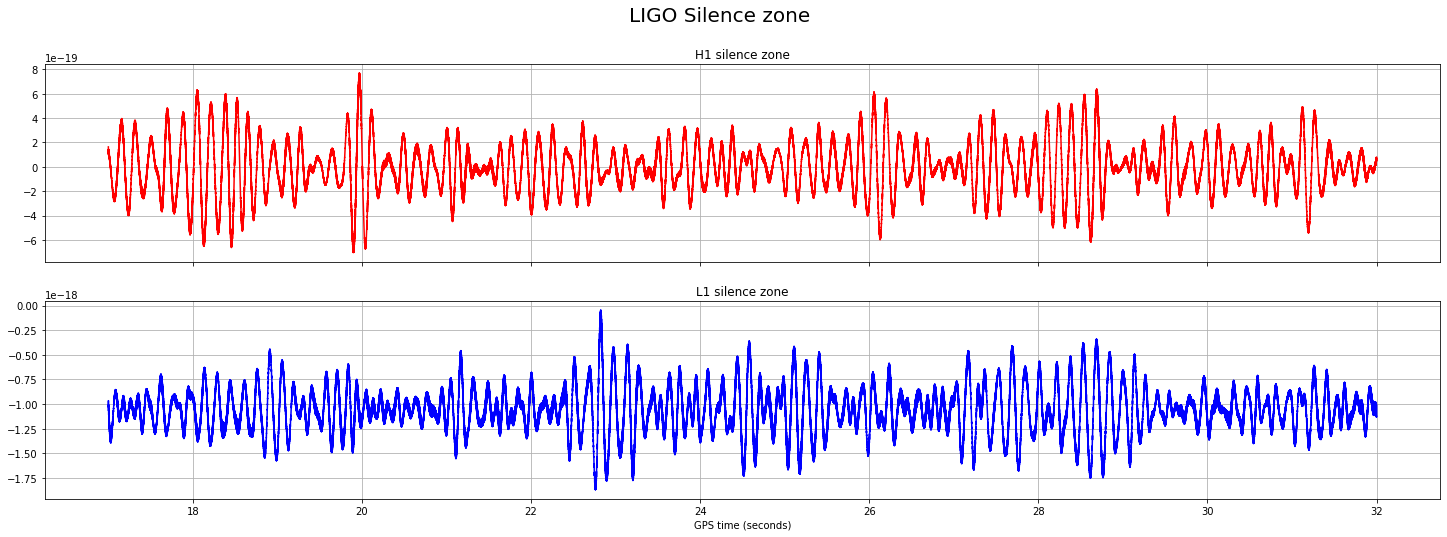

In [9]:
# Plot raw events
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Silence zone',fontsize=20)
axs[0].plot(time_silence, h1_silence, color='red')
axs[1].plot(time_silence, l1_silence, color='blue')
axs[0].set_title('H1 silence zone')
axs[1].set_title('L1 silence zone')
axs[1].set_xlabel('GPS time (seconds)')
axs[0].grid()
axs[1].grid()

# Estimating noise psd

In [10]:
from ej1.periodogram import periodogram
from ej1.per_averaging import periodogram_averaging
from ej1.per_smoothing import periodogram_smoothing

## Periodogram

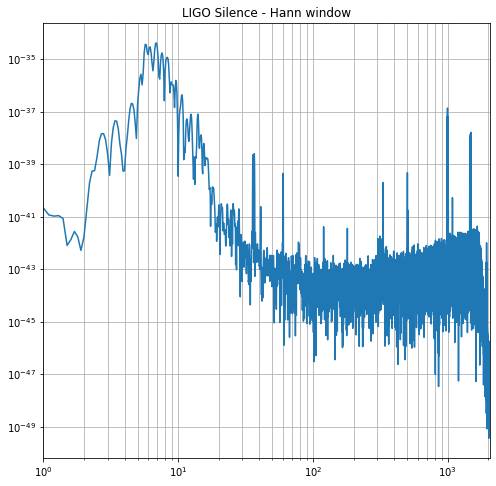

In [11]:
N = int(5 * h1_fs)
f, per = periodogram(h1_silence[:N], window='hann')
plt.figure(figsize=(8,8))
plt.loglog(f*h1_fs,per)
plt.title('LIGO Silence - Hann window')
plt.grid(axis='both', which='both')
plt.xlim((1,f[-1]*h1_fs + 1))
plt.show()

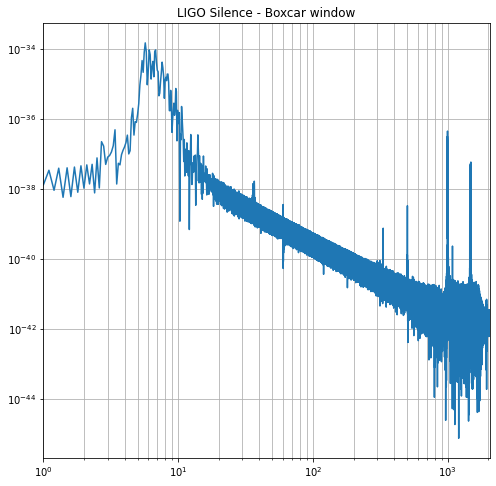

In [12]:
N = int(5 * h1_fs)
f, per = periodogram(h1_silence[:N], window='boxcar')
plt.figure(figsize=(8,8))
plt.loglog(f*h1_fs,per)
plt.title('LIGO Silence - Boxcar window')
plt.grid(axis='both', which='both')
plt.xlim((1,f[-1]*h1_fs + 1))
plt.show()

In [13]:
def plot_periodogram(ax, fs, signal, window):
    f, per = periodogram(signal, window=window)
    f *= fs
    ax.loglog(f,per, label=window)
    ax.grid(axis='both', which='both')

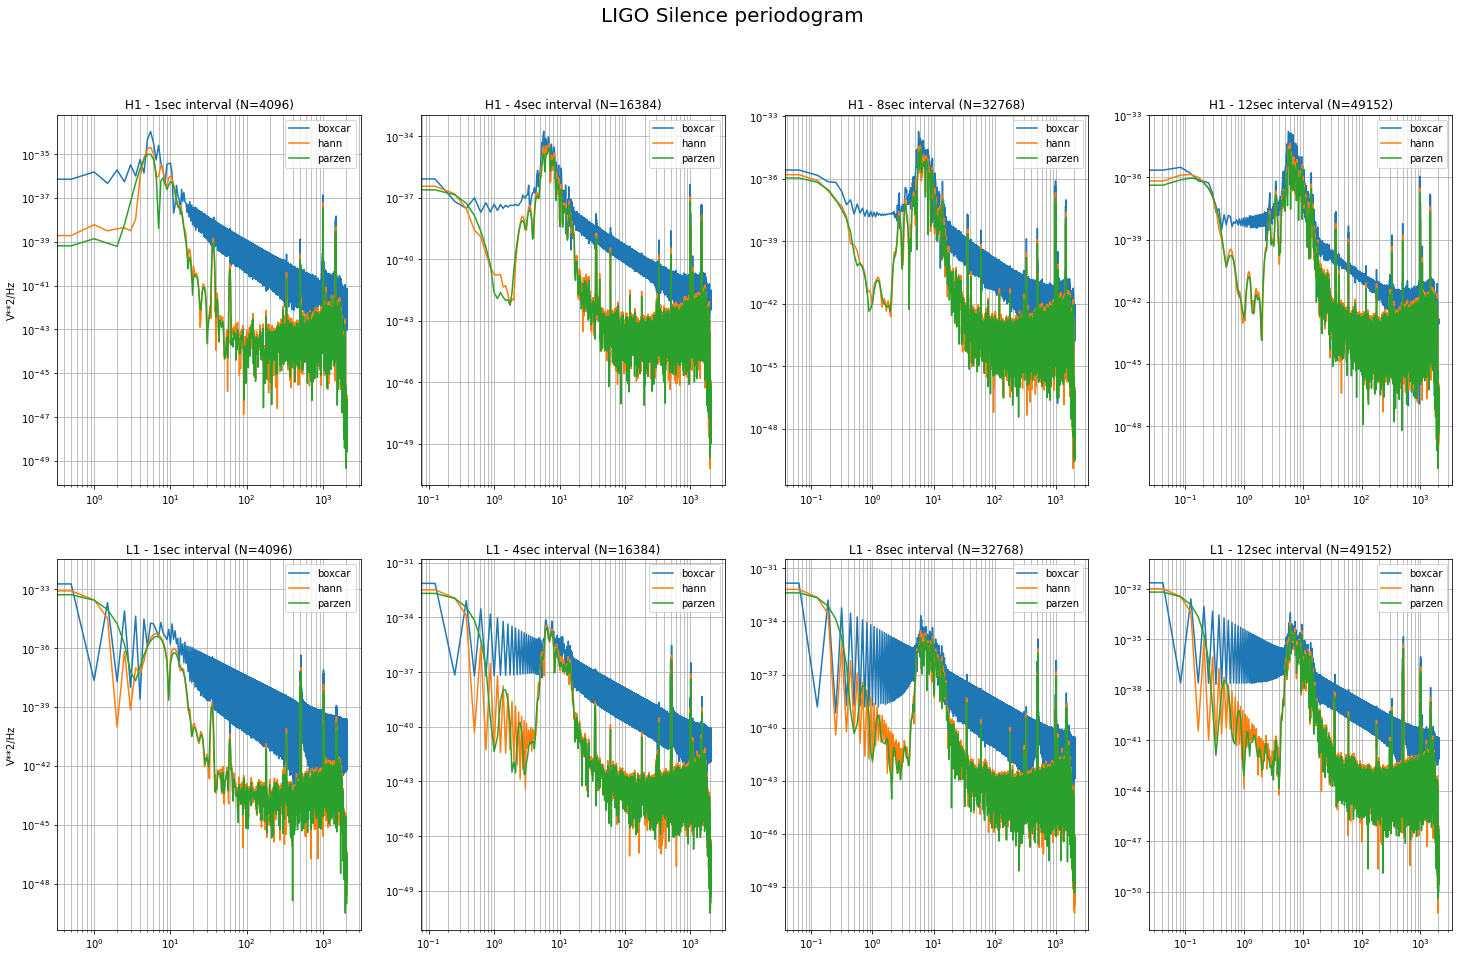

In [14]:
%%time
windows = ['boxcar', 'hann', 'parzen']
samples = [1,4,8,12]
signals = [h1_silence, l1_silence]

fig, axs = plt.subplots(2, 4, figsize=(25,15))
fig.suptitle('LIGO Silence periodogram', fontsize=20)
axs[0][0].set_ylabel('V**2/Hz')
axs[1][0].set_ylabel('V**2/Hz')
for i, s in enumerate(signals):
    for j,sample in enumerate(samples):
        for w in windows:
            plot_periodogram(axs[i][j], h1_fs, s[:int(sample*h1_fs)], w)
        tag = 'H1' if i == 0 else 'L1'
        axs[i][j].set_title(f'{tag} - {sample}sec interval (N={int(sample*h1_fs)})')
        axs[i][j].legend()

## Periodogram averaging

In [15]:
def plot_periodogram_avg(ax, fs, signal, k, overlap):
    D = int(signal.shape[0] / k)
    L = int(D / (1-overlap))
    f, per = periodogram_averaging(signal, k, L)
    f *= fs
    ax.loglog(f,per, label=f'{o*100}% overlap')
    ax.grid(axis='both', which='both')

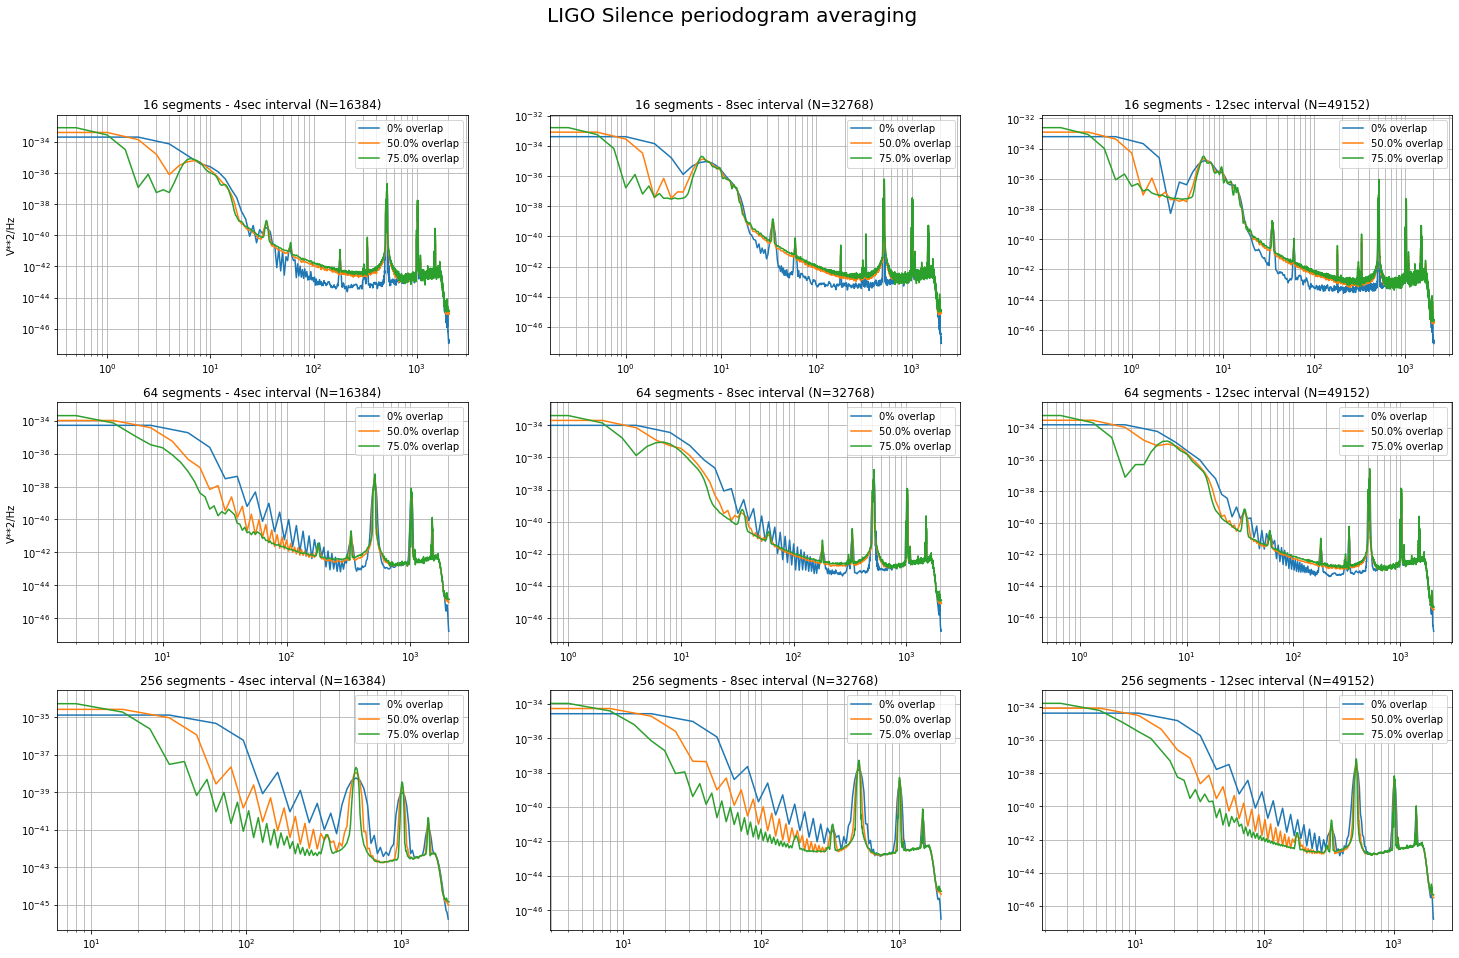

In [16]:
%%time
segments = [16, 64, 256]
samples = [4,8,12]
overlaps = [0,0.5, 0.75]

fig, axs = plt.subplots(3, 3, figsize=(25,15))
fig.suptitle('LIGO Silence periodogram averaging', fontsize=20)
axs[0][0].set_ylabel('V**2/Hz')
axs[1][0].set_ylabel('V**2/Hz')
for i, k in enumerate(segments):
    for j,sample in enumerate(samples):
        for o in overlaps:
            plot_periodogram_avg(axs[i][j], h1_fs, s[:int(sample*h1_fs)], k, o)
        axs[i][j].set_title(f'{k} segments - {sample}sec interval (N={int(sample*h1_fs)})')
        axs[i][j].legend()

## Periodogram smoothing

In [20]:
def plot_periodogram_smoothing(ax, fs, signal, L, window):
    f, per = periodogram_smoothing(signal, L, window=window)
    f *= fs
    ax.loglog(f,per, label=window)
    ax.grid(axis='both', which='both')

Wall time: 1min 2s


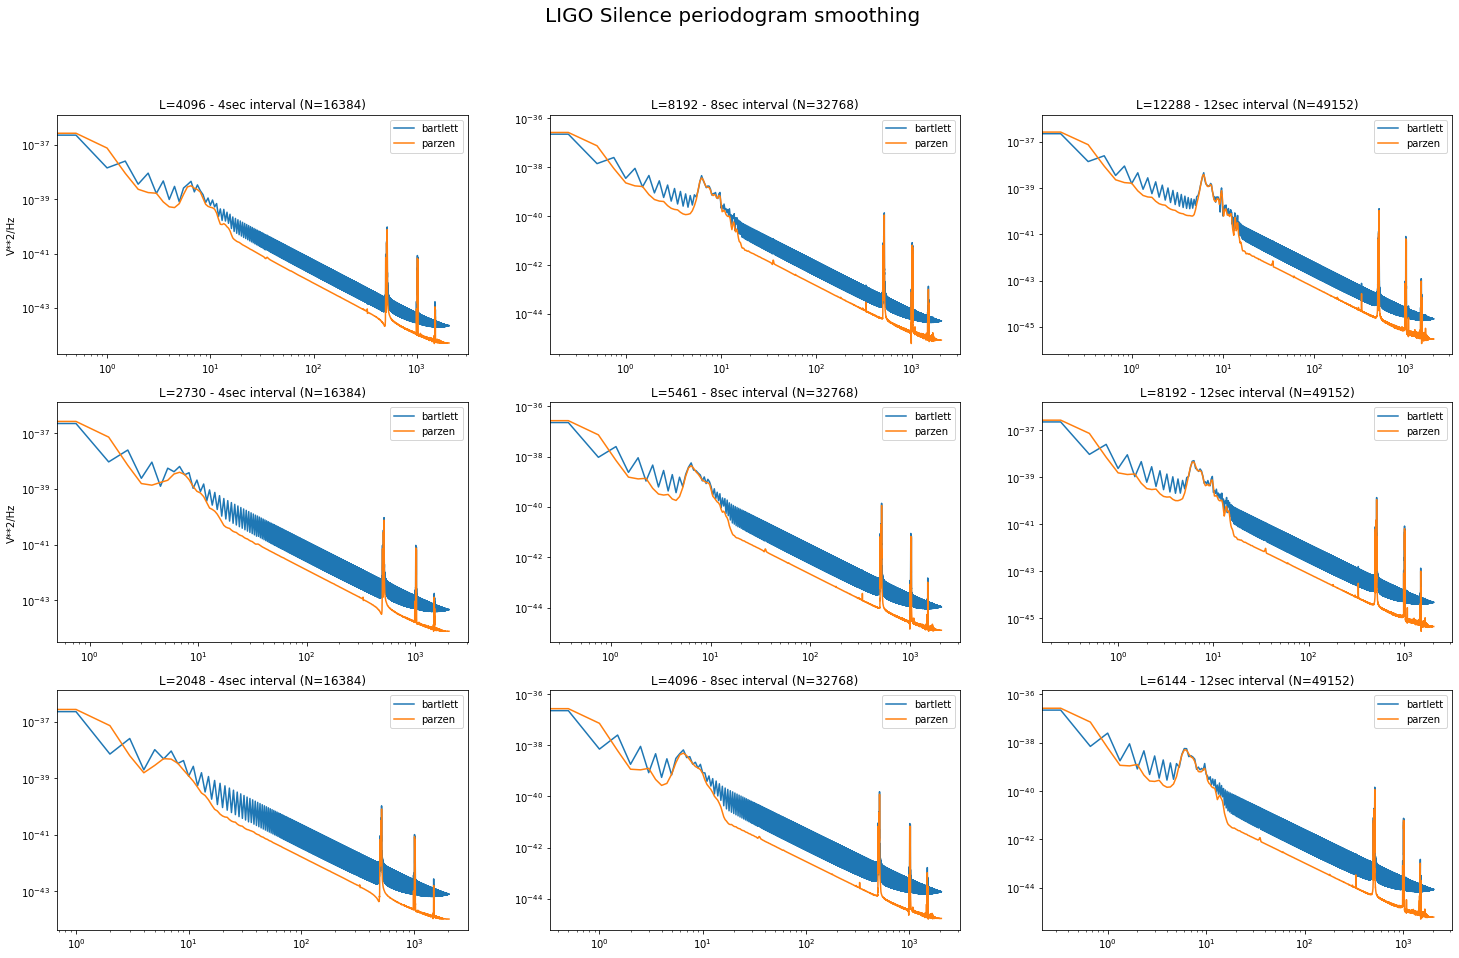

In [23]:
%%time
lengths = [4, 6, 8]
samples = [4,8,12] # seconds
windows = ['bartlett', 'parzen']

fig, axs = plt.subplots(3, 3, figsize=(25,15))
fig.suptitle('LIGO Silence periodogram smoothing', fontsize=20)
axs[0][0].set_ylabel('V**2/Hz')
axs[1][0].set_ylabel('V**2/Hz')
for i, L in enumerate(lengths):
    for j,sample in enumerate(samples):
        for w in windows:
            plot_periodogram_smoothing(axs[i][j], h1_fs, s[:int(sample*h1_fs)], int(sample*h1_fs/L), w)
        axs[i][j].set_title(f'L={int(sample*h1_fs/L)} - {sample}sec interval (N={int(sample*h1_fs)})')
        axs[i][j].legend()

In [1]:
from ej2.whitenning import whiten, band_pass_filter

overlap = 0.5
D = int(h1_s[:32768].shape[0] / k)
L = int(D / (1-overlap))
f, per = periodogram_averaging(h1_s[:32768], k, L)

periodogram_averaging = periodogram_averaging(h1_s, k, L)
whiten(h1_s, per, 1/h1_fs)


NameError: name 'h1_s' is not defined